## Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 112 GB / percent used: 10.9 %


## Load model data

In [2]:
# Define period
period = slice('1981','2014')

In the next cells the `chunks={'time': 120}` allows not to load full data set but take it by chunks of 10 years. This allows to parallelize the computation and/or make fit into the memory (see **xarray/dask**: http://xarray.pydata.org/en/stable/dask.html)

In [3]:
# Load historical
snc_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).sel(time=period).snc

# Load amip
snc_amip = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/amip/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).sel(time=period).snc

# Load land-hist
snc_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/IPSL/IPSL-CM6A-LR/land-hist/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).sel(time=period).snc

In [4]:
# Load HighResMIP
snc_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).sel(time=period).snc
snc_HR

<xarray.DataArray 'snc' (time: 408, lat: 361, lon: 512)>
dask.array<getitem, shape=(408, 361, 512), dtype=float32, chunksize=(408, 361, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 0.0 0.703125 1.40625 ... 358.59375 359.29688
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

## Load Rutger University data set

In [5]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)

### Get the snc variable, keep only land data, convert to % and resample by months
Resampling with xarray: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html  
**Offset aliases**: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases  
Here we use: **MS**	month start frequency

In [6]:
# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    snc_rutger = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
    
snc_rutger.attrs['units'] = '%'

# Rename lon and lat for the regrid
snc_rutger = snc_rutger.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
snc_rutger = snc_rutger.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)
snc_rutger

/home/mlalande/miniconda3/lib/python3.7/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/home/mlalande/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'snow_cover_extent' (time: 408, rows: 88, cols: 88)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-01 ... 2014-12-01
    snow_cover_threshold  float32 0.42
    lat                   (rows, cols) float64 0.6592 1.322 ... 1.322 0.6592
    lon                   (rows, cols) float64 145.0 144.3 ... -35.67 -35.0
Dimensions without coordinates: rows, cols
Attributes:
    long_name:      NOAA/NCDC Climate Data Record of snow cover extent
    standard_name:  surface_snow_binary_mask
    grid_mapping:   coord_system
    valid_range:    [0 1]
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered
    units:          %

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/)
Value of cells in the new grid that are outside the old grid's domain #15 (https://github.com/JiaweiZhuang/xESMF/issues/15)

In [7]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder = xe.Regridder(snc_rutger, snc_historical, 'bilinear', periodic=False)
regridder = add_matrix_NaNs(regridder)
print(regridder)

# Regrid the data
snc_rutger_regrid = regridder(snc_rutger)

Overwrite existing file: bilinear_88x88_143x144.nc 
 You can set reuse_weights=True to save computing time.


/home/mlalande/miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_88x88_143x144.nc 
Reuse pre-computed weights? False 
Input grid shape:           (88, 88) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False


Text(0.5, 1.0, 'IPSL_CM6A_LR grid 143x144')

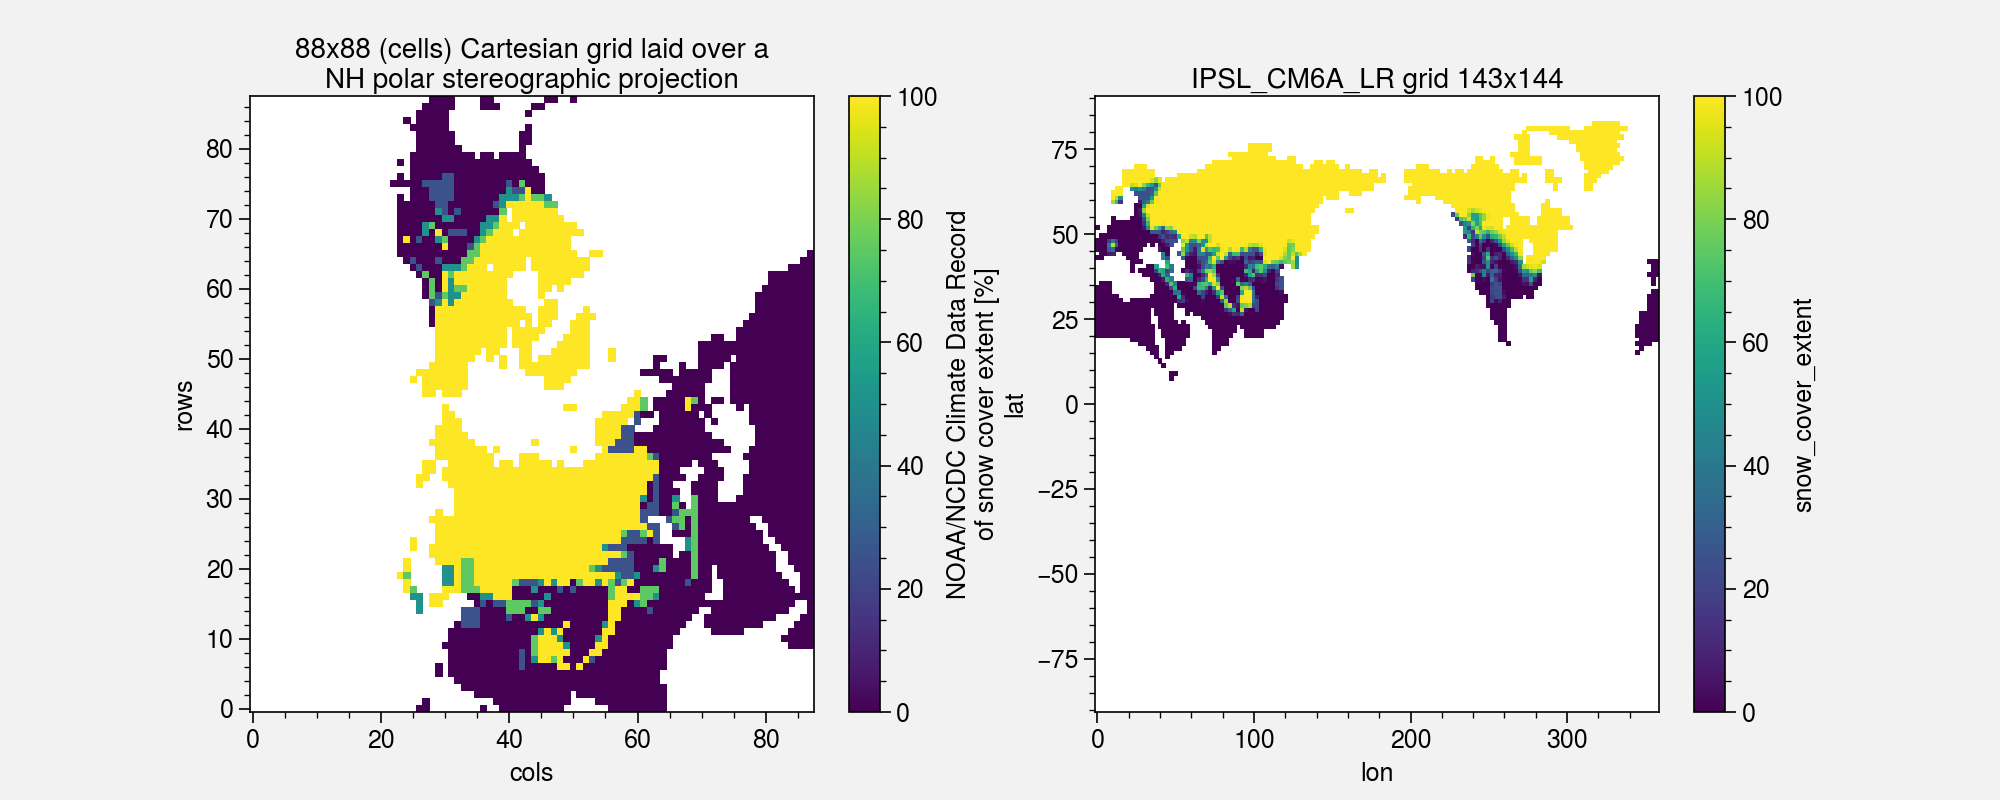

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(121)
snc_rutger[0].plot()
plt.title('88x88 (cells) Cartesian grid laid over a\nNH polar stereographic projection')
plt.subplot(122)
snc_rutger_regrid[0].plot()
plt.title('IPSL_CM6A_LR grid 143x144')

In [9]:
# Regrid HighResMIP
regridder = xe.Regridder(snc_HR, snc_historical, 'bilinear', periodic=True)
regridder

Overwrite existing file: bilinear_361x512_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [10]:
# Regrid the data
snc_HR_regrid = regridder(snc_HR)

## Climatology

In [11]:
snc_historical_clim = u.clim(snc_historical)
snc_historical_clim.load()

snc_amip_clim = u.clim(snc_amip)
snc_amip_clim.load()

snc_land_hist_clim = u.clim(snc_land_hist)
snc_land_hist_clim.load()

snc_rutger_regrid_clim = u.clim(snc_rutger_regrid)
snc_rutger_regrid_clim.load()

snc_HR_regrid_clim = u.clim(snc_HR_regrid)
snc_HR_regrid_clim.load()

<xarray.DataArray (lat: 143, lon: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
Attributes:
    regrid_method:  bilinear

In [95]:
latlim=(10,50)
lonlim=(60,110)

bias = xr.concat(
    [
        snc_historical_clim-snc_rutger_regrid_clim,
        snc_amip_clim-snc_rutger_regrid_clim,
        snc_land_hist_clim-snc_rutger_regrid_clim,
        snc_HR_regrid_clim-snc_rutger_regrid_clim
    ],
    pd.Index(
        [
            'Historical (143x144) - NOAA CDR (88x88 NH)',
            'AMIP (143x144) - NOAA CDR (88x88 NH)',
            'land-hist (143x144) - NOAA CDR (88x88 NH)',
            'HighResMIP (361x512) - NOAA CDR (88x88 NH)'
        ], 
        name='bias'
    )
).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))

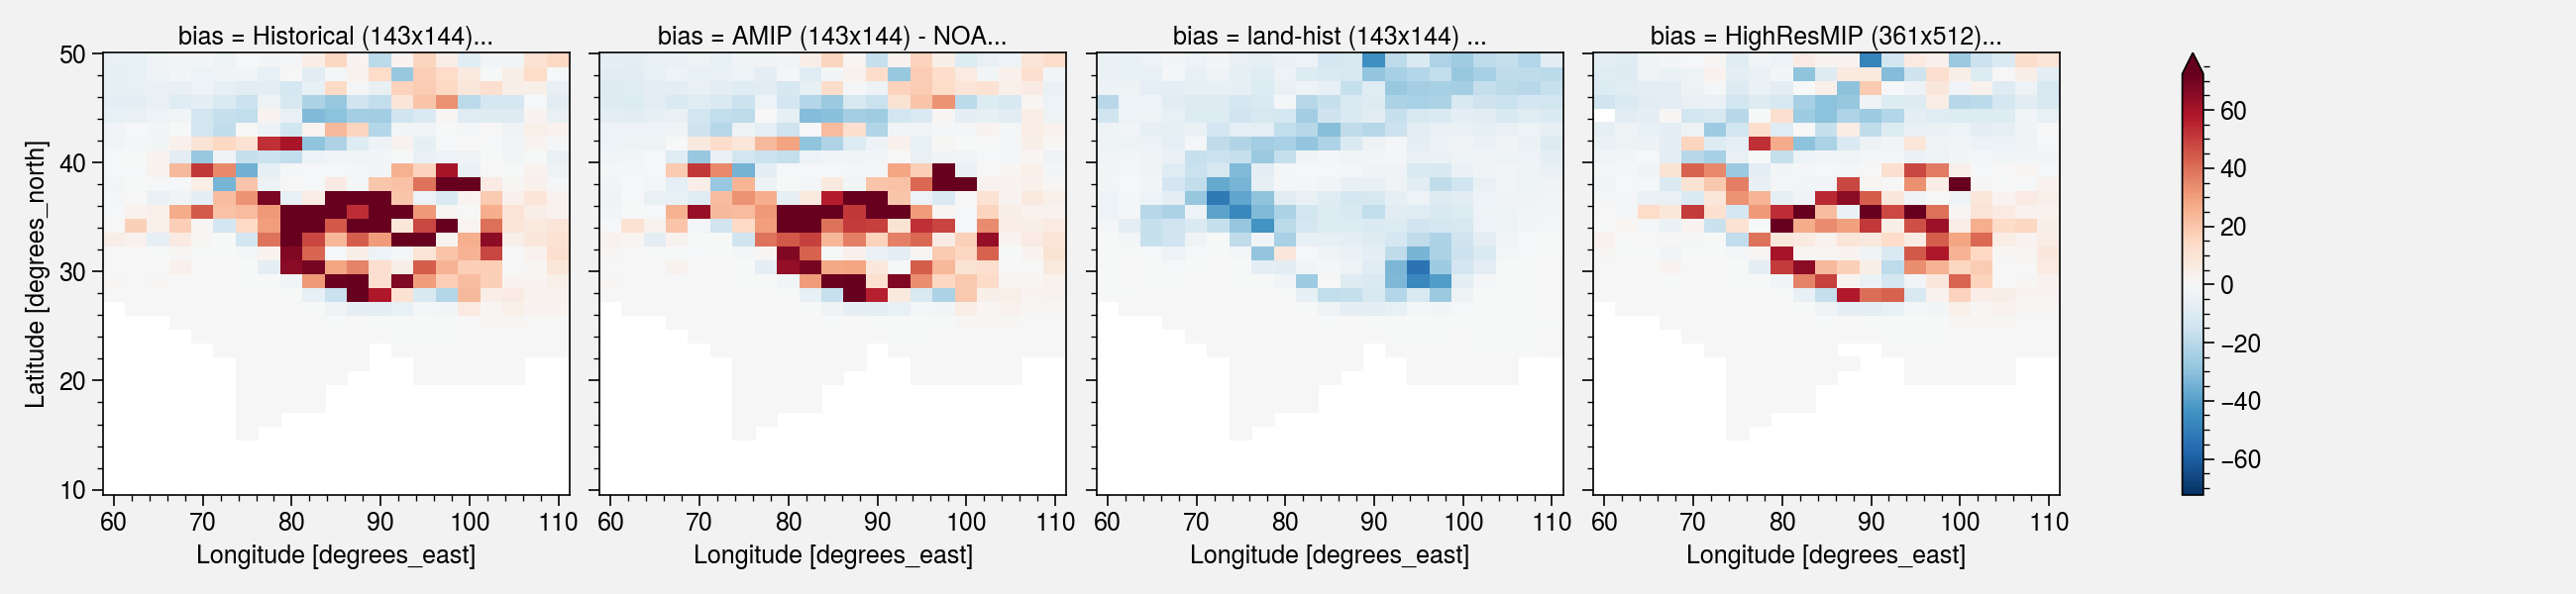

In [96]:
bias.plot(col='bias', robust=True)

In [108]:
bias.max()

<xarray.DataArray ()>
array(90.76925091)
Coordinates:
    snow_cover_threshold  float32 0.42

In [109]:
bias.min()

<xarray.DataArray ()>
array(-53.33603593)
Coordinates:
    snow_cover_threshold  float32 0.42

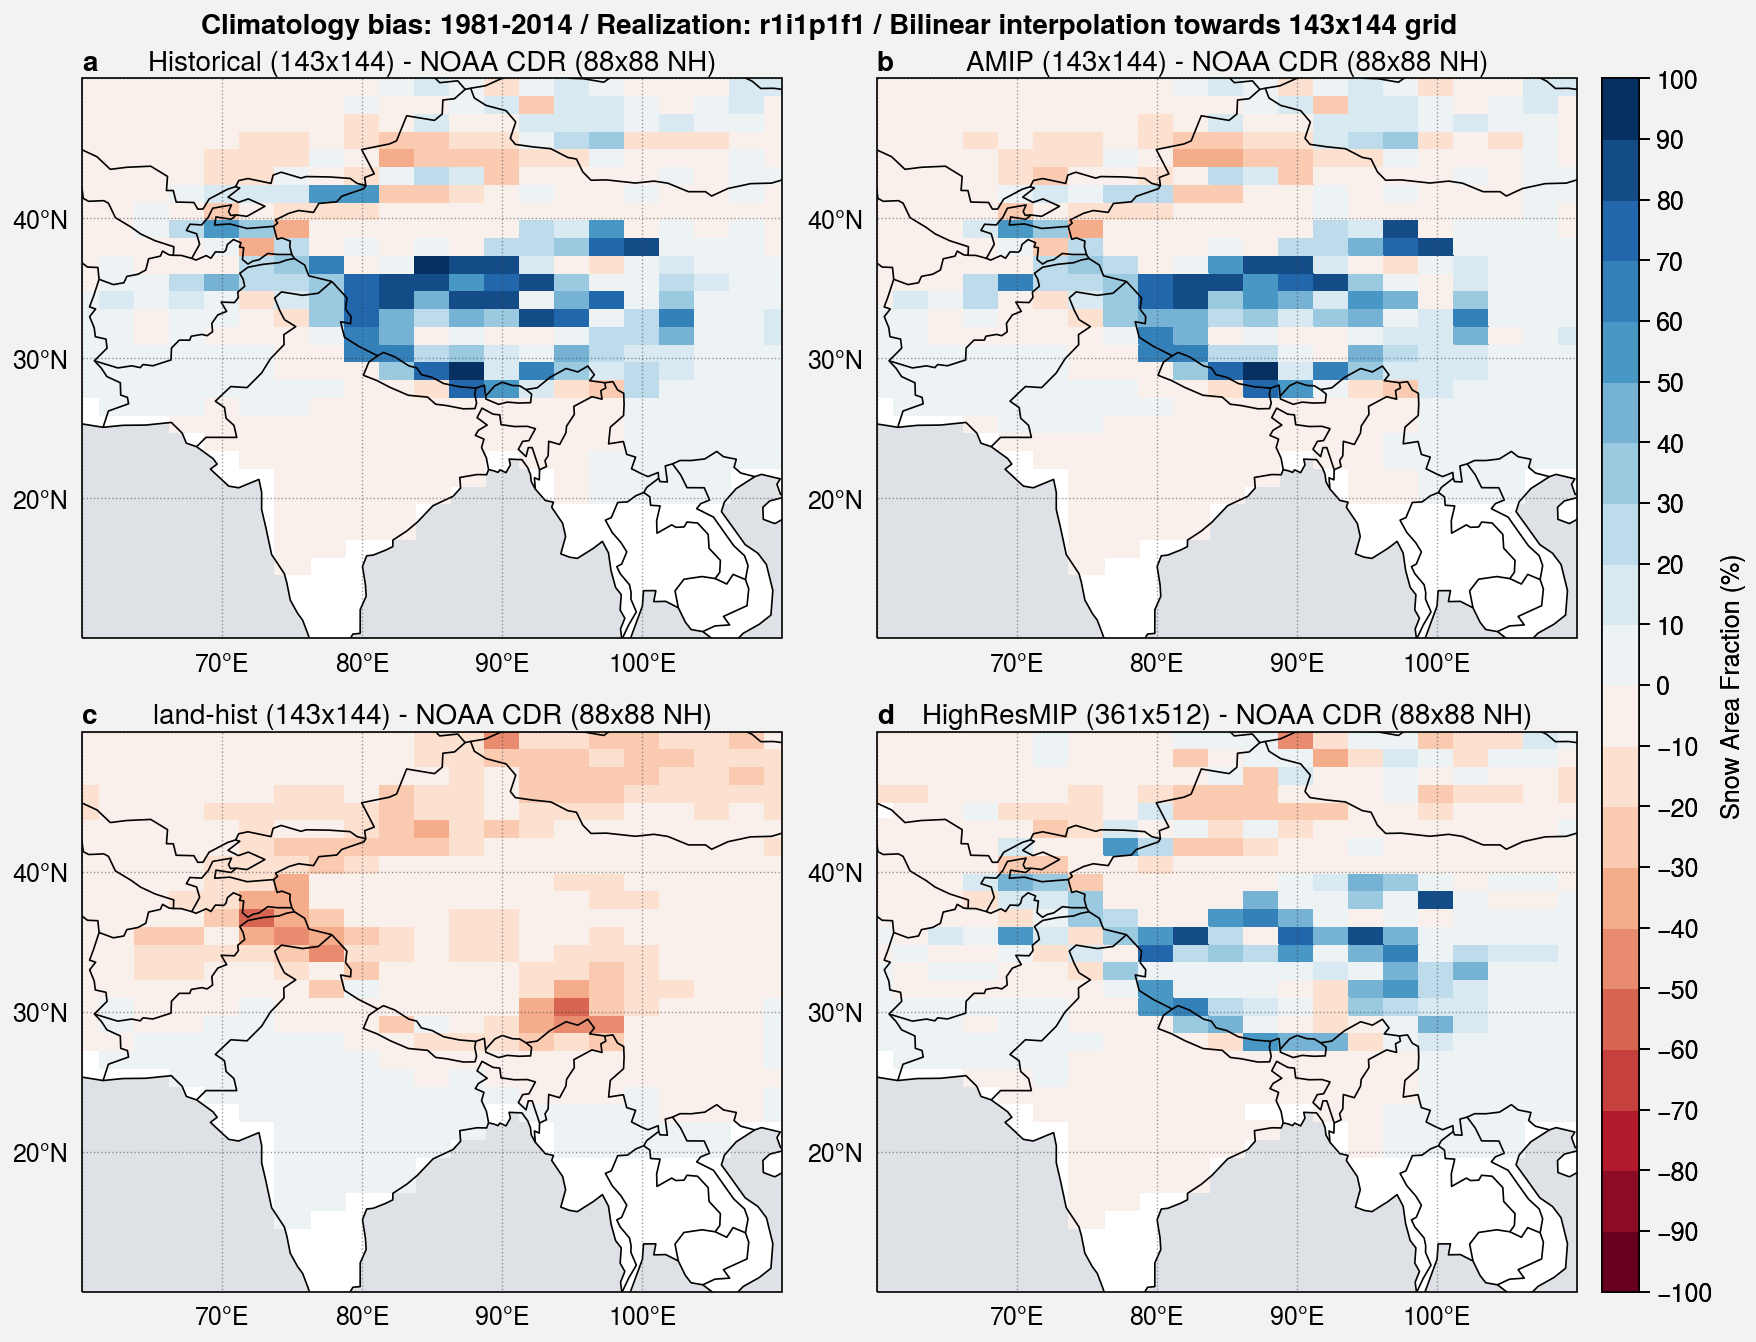

In [113]:
# Final plot

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3.5)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        diff.isel(bias=i).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), 
        cmap='RdBu', 
        levels=plot.arange(-100,100,10), 
    #     extend='both',
#         norm='midpoint'
    )
    ax.format(title=str(diff.isel(bias=i).bias.values))

f.colorbar(m, label='Snow Area Fraction (%)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Climatology bias: 1981-2014 / Realization: r1i1p1f1 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('bias_hist_amip_land.png')

In [15]:
orog = xr.open_dataarray(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc'
)

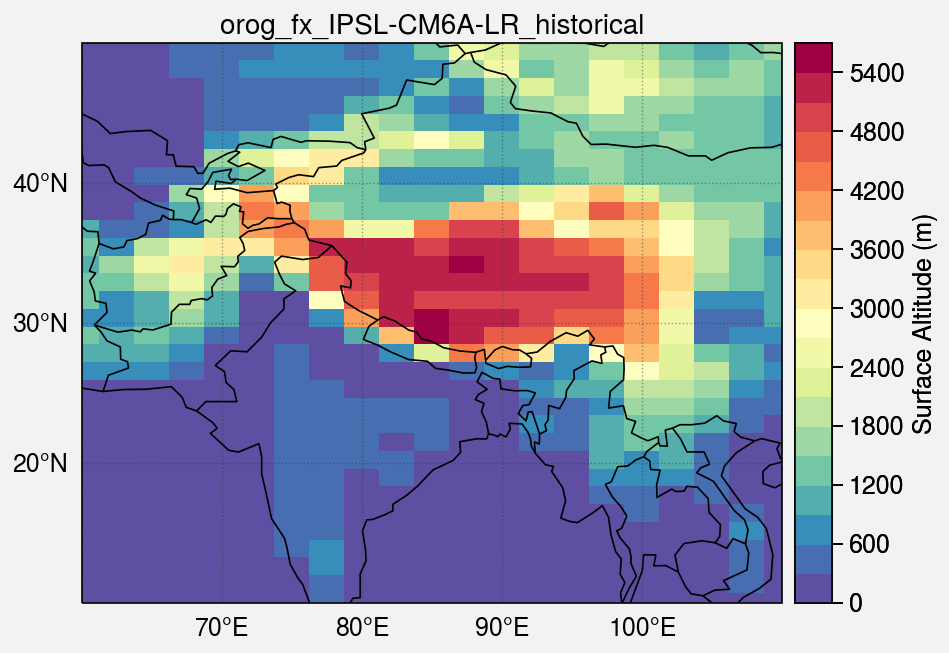

In [29]:
# Differences from Rutger
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, share=3, axwidth=3.5)

m = axs[0].pcolormesh(
    orog.sel(lat=slice(10,50), lon=slice(60,110)),
    colorbar='r',
    levels=20,
    cmap='Spectral'
)
axs[0].format(title='orog_fx_IPSL-CM6A-LR_historical')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110)
)